# Importings

- mutual information 
- search for the catboost regressor on kaggle 

In [182]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor   
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
import xgboost as xgb 
from sklearn.cluster import KMeans
from path import Path
path = Path('/kaggle/input/zindi-geoai-ground-level-no2-estimation-challenge')
train = pd.read_csv(path /'Train.csv') 
test = pd.read_csv(path /'Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)


In [183]:
train = train.dropna(subset=['GT_NO2'])
train.isnull().sum()
#in order to the catboost model to be evaluated

ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   37594
AAI                   12118
CloudFraction         12118
NO2_strat             12118
NO2_total             12118
NO2_trop              33429
TropopausePressure    12118
GT_NO2                    0
dtype: int64

# Feature Engineering

In [184]:
"""agg_funcs = ['mean', 'std', 'min', 'max'] 

def add_aggregated_features(dataset, columns, funcs):
    dataset = dataset.copy()
    for column in columns:
        agg_features_id = dataset.groupby('ID')[column].agg(funcs)
        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]
        dataset = dataset.merge(agg_features_id, on='ID')
    return dataset
train = add_aggregated_features(train, columns_to_aggregate, agg_funcs)
test = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"""

"agg_funcs = ['mean', 'std', 'min', 'max'] \n\ndef add_aggregated_features(dataset, columns, funcs):\n    dataset = dataset.copy()\n    for column in columns:\n        agg_features_id = dataset.groupby('ID')[column].agg(funcs)\n        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]\n        dataset = dataset.merge(agg_features_id, on='ID')\n    return dataset\ntrain = add_aggregated_features(train, columns_to_aggregate, agg_funcs)\ntest = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"

In [185]:
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [186]:
lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 3
num_clusters_lon = 4
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = int((row['LAT'] - lat_min) / lat_step)
    lon_cluster = int((row['LON'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min
    )
print("Train dataset with clusters:\n", train)
print("\nTest dataset with clusters:\n", test)


Train dataset with clusters:
         ID_Zindi      Date     ID        LAT        LON  Precipitation  \
0      ID_ENTGC7    1/1/19   PD01  45.601585  11.903551       0.000000   
1      ID_8JCCXC    1/1/19   PD04  45.371005  11.840830       3.047342   
2      ID_V3136Z    1/1/19   RO01  45.045825  12.060869       0.000000   
3      ID_KRVZDJ    1/1/19   RO02  45.104075  11.553241       1.200467   
4      ID_PR351A    1/1/19   RO03  45.038758  11.790152       1.274564   
...          ...       ...    ...        ...        ...            ...   
86579  ID_NCWXIY  31-12-21  X9897  45.498227   9.556232       0.000000   
86580  ID_UDQIEE  31-12-21  X9928  45.142541  10.043836       0.000000   
86581  ID_ENDUPX  31-12-21  X9969  45.842207   9.351658       0.000000   
86582  ID_3ZBA6C  31-12-21  X9993  45.113503   8.874065       0.000000   
86583  ID_GWG0LD  31-12-21  X9999  45.526473   9.515980       0.000000   

          LST       AAI  CloudFraction  NO2_strat  NO2_total  NO2_trop  \
0      

In [187]:
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,lat_cluster,lon_cluster
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000,2,3
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000,1,3
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000,0,3
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000,0,2
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750,1,0
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125,0,1
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325,2,0
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250,0,0


In [188]:
"""train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    #df['target_month'] = df['Month'].map(df[['Month','GT_NO2']].groupby('Month')['GT_NO2'].mean())
    #df['Month_start'] = df['Date'].dt.is_month_start
    #df['Year'] =  df['Date'].dt.year
    #df.set_index(df['Date'],inplace=True)
    #df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df.drop(columns=['ID_Zindi'],inplace=True)
    
#Linterations
#for df in(train,test):
    #df['NO2_strat_lag_1'] = df['NO2_strat'].shift(1)
    #df['NO2_strat_lag_7'] = df['NO2_strat'].shift(7)
    #df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    #df['Precipitation_log'] =  np.log(df['Precipitation'] + 1e-9)
    #df['CloudFraction_diff'] = df['CloudFraction'] / df['NO2_strat']
    #df['CloudFraction_diff2'] = df['CloudFraction'] / df['NO2_total']
    #['Precipitation_fractional'] = df['Precipitation'] * 0.00001
    #df['TropopausePressure_fractional'] = round(df['TropopausePressure'] * 0.00001,2)
    #df['cluster'] = kmeans.fit_transform(df[['LAT', 'LON']])
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']

#for df in(train,test): 
    #Rolling (Moving Average)
    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()
#statsitics of similar variables

"""def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')
MeanSd('LON','LAT')"""

/tmp/ipykernel_33/3170437766.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipykernel_33/3170437766.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'def MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)\n\nMeanSd(\'NO2_trop\',\'NO2_total\')\nMeanSd(\'LON\',\'LAT\')'

In [189]:
#for df in(train,test): 
    #df['LST_mean_60'] = df['LST'].rolling(60).mean()
    #df['Prec_mean_60'] = df['Precipitation'].rolling(60).mean()
    #df['AII_mean'] = df['AAI'].rolling(60).mean()
    #df['no2_total'] = df['NO2_total'].rolling(60).min()

    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()


def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
#rolling('AAI')
#rolling('LST')
rolling('Precipitation')

In [190]:
"""columns_to_aggregate = [
    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat', 
    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction', 
    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60', 
    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'
]
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')
        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')
        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')
        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()
        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()
        df[f'{col}_rolling_max_30'] = df[col].rolling(window=30).max()
        df[f'{col}_rolling_min_30'] = df[col].rolling(window=30).min()"""

"columns_to_aggregate = [\n    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat', \n    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction', \n    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60', \n    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'\n]\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')\n        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')\n        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')\n        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')\n\ndf['Date'] = pd.to_datetime(df['Date'])\ndf = df.set_index('Date')\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()\n        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()\n  

# Missing Values & Encoding

In [191]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=["Date",'ID','Precipitation','CloudFraction','AAI'], axis=1,inplace=True)

In [192]:
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

In [193]:
#train = train.dropna(axis=0)

In [194]:
"""from sklearn.feature_selection import mutual_info_regression
from prettytable import PrettyTable

X = train.drop('GT_NO2', axis=1)
y = train['GT_NO2']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="Mutual Information", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

pretty_table = PrettyTable()
pretty_table.field_names = ["Feature", "Mutual Information"]

for feature, mi_score in mi_scores.items():
    pretty_table.add_row([feature, round(mi_score, 3)])

print(pretty_table)"""

'from sklearn.feature_selection import mutual_info_regression\nfrom prettytable import PrettyTable\n\nX = train.drop(\'GT_NO2\', axis=1)\ny = train[\'GT_NO2\']\n\nmi_scores = mutual_info_regression(X, y)\nmi_scores = pd.Series(mi_scores, name="Mutual Information", index=X.columns)\nmi_scores = mi_scores.sort_values(ascending=False)\n\npretty_table = PrettyTable()\npretty_table.field_names = ["Feature", "Mutual Information"]\n\nfor feature, mi_score in mi_scores.items():\n    pretty_table.add_row([feature, round(mi_score, 3)])\n\nprint(pretty_table)'

# CV and Modeling

In [195]:
#train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [196]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lat_cluster', 'lon_cluster', 'Month',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')

In [197]:
#model =  LGBMRegressor(random_state=7)
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
model = CatBoostRegressor(random_state=7)
#model = XGBRegressor(random_state= 7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)

    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)
print('RMSEs Deviations:', rmse)

Learning rate set to 0.07922
0:	learn: 16.9536158	total: 9.78ms	remaining: 9.77s
1:	learn: 16.3350091	total: 19ms	remaining: 9.49s
2:	learn: 15.7814712	total: 28ms	remaining: 9.3s
3:	learn: 15.2772870	total: 37.5ms	remaining: 9.33s
4:	learn: 14.8347290	total: 47.1ms	remaining: 9.37s
5:	learn: 14.4588905	total: 56.4ms	remaining: 9.35s
6:	learn: 14.1038326	total: 66.2ms	remaining: 9.39s
7:	learn: 13.7912278	total: 75.6ms	remaining: 9.37s
8:	learn: 13.5181917	total: 85ms	remaining: 9.35s
9:	learn: 13.2364244	total: 93.9ms	remaining: 9.3s
10:	learn: 13.0139928	total: 103ms	remaining: 9.26s
11:	learn: 12.8098306	total: 112ms	remaining: 9.23s
12:	learn: 12.6286587	total: 121ms	remaining: 9.19s
13:	learn: 12.4565915	total: 130ms	remaining: 9.16s
14:	learn: 12.3086252	total: 140ms	remaining: 9.17s
15:	learn: 12.1844013	total: 148ms	remaining: 9.12s
16:	learn: 12.0662808	total: 157ms	remaining: 9.09s
17:	learn: 11.9535384	total: 166ms	remaining: 9.08s
18:	learn: 11.8486306	total: 175ms	remainin

In [198]:
#10.155311364148783 catboost leaderboard best s far 9.525616244 
#9.920018431939276 catboost and added the day features - probably it overfits - indeed 
#9.43514150859055 removing all missing values leaderboard 11.9315086
#10.139203906659699 
#10.201862135497844 the effect of mutual information
#9.476601295728365 
#10.025125392453269

In [199]:
#11.581549939504997 with month , 
#12.246931687286574
#12.235259341356834
#12.231869616518921
#12.126333476852636
#11.728753513719479
#11.724263538742687
#11.728753513719479 
#11.711277895239192
#11.694341231865433
#11.671982426722977
#11.642227859275334 without the mean - with the custamized means of rolling
#11.314985626750522 
#11.314985626750522
#11.312413659993586
#11.135932399851725 
#11.728753513719479 best so far features = ['LAT', 'Month','NO2_trop_rolling_max_60','NO2_total_rolling_max_60','TropopausePressure_rolling_max_60','CloudFraction_rolling_max_60','Precipitation_rolling_max_60']
#11.40320255907346 with the ID LB = 9.571700669
#11.597286160951526 the distance feature

In [200]:
"""@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Removed feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def lofo_analysis(train, target_col, groups, n_splits):
    base_rmse = []
    for train_idx, test_idx in cv.split(train.drop(columns=target_col), train[target_col], groups=groups):
        train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
        base_rmse.append(validate(train_v, test_v, target_col))
    base_score = np.array(base_rmse).mean()
    print('Base RMSE:', base_score)

    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')  # Ensure the feature being evaluated is printed
        for train_idx, test_idx in cv.split(train.drop(columns=[target_col, col]), train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v.drop(columns=col), test_v.drop(columns=col), target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} removed, RMSE: {feature_rmse}')  # Print the removal of the feature and its RMSE

    bad_features = [col for col in feature_importances if feature_importances[col] > base_score]
    good_features = [col for col in feature_importances if feature_importances[col] <= base_score]
    
    print('Good features:', good_features)
    print('Bad features:', bad_features)
    
    return good_features, bad_features, feature_importances

# Assuming 'train' and 'groups' DataFrame and Series are defined elsewhere in your code
good_features, bad_features, feature_importances = lofo_analysis(train, 'GT_NO2', groups, n_splits)

print('Feature importances:')
for feature, importance in feature_importances.items():
    print(f'{feature}: {importance}')"""

"@contextlib.contextmanager\ndef suppress_output():\n    with open(os.devnull, 'w') as devnull:\n        old_stdout = sys.stdout\n        old_stderr = sys.stderr\n        sys.stdout = devnull\n        sys.stderr = devnull\n        try:\n            yield\n        finally:\n            sys.stdout = old_stdout\n            sys.stderr = old_stderr\n\ndef validate(trainset, testset, target_col, feature_name=None):\n    with suppress_output():\n        model.fit(trainset.drop(columns=target_col), trainset[target_col])\n    pred = model.predict(testset.drop(columns=target_col))\n    valid_idx = testset[target_col].notna()\n    valid_testset = testset[target_col][valid_idx]\n    valid_pred = pred[valid_idx]\n    score = mean_squared_error(valid_testset, valid_pred, squared=False)\n    if feature_name:\n        print(f'Removed feature: {feature_name} | Validation MSE: {score}')\n    else:\n        print(f'Validation MSE: {score}')\n    return score\n\ndef lofo_analysis(train, target_col, group

In [201]:
bad_features

['LAT',
 'LON',
 'LST',
 'NO2_strat',
 'NO2_total',
 'Month',
 'NO2_trop_rolling_max_60',
 'NO2_total_rolling_max_60',
 'TropopausePressure_rolling_max_60',
 'CloudFraction_rolling_max_60',
 'Precipitation_rolling_max_60']

In [202]:
"""@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using features: NO2_total, NO2_trop, {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score
def feature_combination_analysis(train, target_col, groups, n_splits):
    base_features = ['NO2_total', 'NO2_trop']
    additional_features = [col for col in train.drop(columns=target_col).columns if col not in base_features]
    
    feature_importances = {}
    for col in additional_features:
        scores = []
        print(f'Evaluating feature: {col}')  
        for train_idx, test_idx in cv.split(train[[target_col] + base_features + [col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col] + base_features + [col]], test_v[[target_col] + base_features + [col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} with base features, RMSE: {feature_rmse}')  
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])
    
    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')
    
    return feature_importances

feature_importances = feature_combination_analysis(train, 'GT_NO2', groups, n_splits)"""

"@contextlib.contextmanager\ndef suppress_output():\n    with open(os.devnull, 'w') as devnull:\n        old_stdout = sys.stdout\n        old_stderr = sys.stderr\n        sys.stdout = devnull\n        sys.stderr = devnull\n        try:\n            yield\n        finally:\n            sys.stdout = old_stdout\n            sys.stderr = old_stderr\n\ndef validate(trainset, testset, target_col, feature_name=None):\n    with suppress_output():\n        model.fit(trainset.drop(columns=target_col), trainset[target_col])\n    pred = model.predict(testset.drop(columns=target_col))\n    valid_idx = testset[target_col].notna()\n    valid_testset = testset[target_col][valid_idx]\n    valid_pred = pred[valid_idx]\n    score = mean_squared_error(valid_testset, valid_pred, squared=False)\n    if feature_name:\n        print(f'Using features: NO2_total, NO2_trop, {feature_name} | Validation MSE: {score}')\n    else:\n        print(f'Validation MSE: {score}')\n    return score\ndef feature_combination_

In [203]:
"""@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def single_feature_analysis(train, target_col, groups, n_splits):
    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')  
        for train_idx, test_idx in cv.split(train[[target_col, col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col, col]], test_v[[target_col, col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} only, RMSE: {feature_rmse}') 
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])
    
    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')
    
    return feature_importances
feature_importances = single_feature_analysis(train, 'GT_NO2', groups, n_splits)"""

"@contextlib.contextmanager\ndef suppress_output():\n    with open(os.devnull, 'w') as devnull:\n        old_stdout = sys.stdout\n        old_stderr = sys.stderr\n        sys.stdout = devnull\n        sys.stderr = devnull\n        try:\n            yield\n        finally:\n            sys.stdout = old_stdout\n            sys.stderr = old_stderr\n\ndef validate(trainset, testset, target_col, feature_name=None):\n    with suppress_output():\n        model.fit(trainset.drop(columns=target_col), trainset[target_col])\n    pred = model.predict(testset.drop(columns=target_col))\n    valid_idx = testset[target_col].notna()\n    valid_testset = testset[target_col][valid_idx]\n    valid_pred = pred[valid_idx]\n    score = mean_squared_error(valid_testset, valid_pred, squared=False)\n    if feature_name:\n        print(f'Using feature: {feature_name} | Validation MSE: {score}')\n    else:\n        print(f'Validation MSE: {score}')\n    return score\n\ndef single_feature_analysis(train, target_co

In [204]:
hshsd

NameError: name 'hshsd' is not defined

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y = model.predict(test)
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/SampleSubmission.csv')
smaple['GT_NO2'] = post_process(test,y)
smaple.to_csv('submissionpost2.csv',index=False)

In [205]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('submission10.025125392453269.csv', index=False)

Learning rate set to 0.082149
0:	learn: 16.4174826	total: 11.7ms	remaining: 11.7s
1:	learn: 15.8132781	total: 22.9ms	remaining: 11.4s
2:	learn: 15.2562623	total: 34.2ms	remaining: 11.4s
3:	learn: 14.7698362	total: 46.5ms	remaining: 11.6s
4:	learn: 14.3488681	total: 58.3ms	remaining: 11.6s
5:	learn: 13.9852213	total: 69.5ms	remaining: 11.5s
6:	learn: 13.6578016	total: 81ms	remaining: 11.5s
7:	learn: 13.3591161	total: 92.2ms	remaining: 11.4s
8:	learn: 13.0988177	total: 103ms	remaining: 11.4s
9:	learn: 12.8419735	total: 114ms	remaining: 11.3s
10:	learn: 12.6253828	total: 125ms	remaining: 11.2s
11:	learn: 12.4448494	total: 136ms	remaining: 11.2s
12:	learn: 12.2855552	total: 147ms	remaining: 11.2s
13:	learn: 12.1371779	total: 159ms	remaining: 11.2s
14:	learn: 11.9955218	total: 169ms	remaining: 11.1s
15:	learn: 11.8845870	total: 181ms	remaining: 11.1s
16:	learn: 11.7628617	total: 196ms	remaining: 11.3s
17:	learn: 11.6569153	total: 207ms	remaining: 11.3s
18:	learn: 11.5658203	total: 217ms	rem

In [ ]:
model.feature_importances_

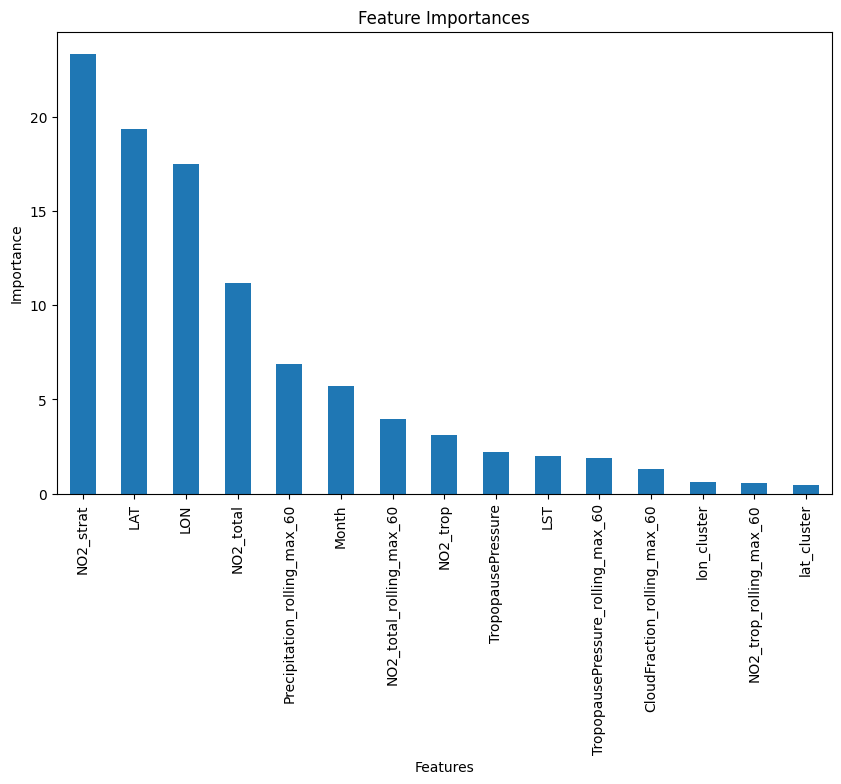

In [206]:
importances = model.feature_importances_
names = model.feature_names_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [207]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lat_cluster', 'lon_cluster', 'Month',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')